In [4]:
import pandas as pd
import numpy as np
import pyjags
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

---
## Behavioral model: EZ Bayesian 

In [5]:
# read data
data_summary_df = pd.read_csv('../data/data_summary.csv')
data_summary_df

,Unnamed: 0,ID,rt_mean,rt_sd,right_count,left_count,accuracy_sum,accuracy_sum_with_omissions,omissions,num_trials,accuracy,BIS,AAC-FULL,Dickman-Impulsivity
0,0,0,0.330821,0.003720,162,158,316,316,0,320,0.987500,0.584046,-0.712524,2.096673
1,1,1,0.425735,0.023621,161,161,322,322,0,322,1.000000,1.172450,-0.316936,-1.092494
2,2,2,0.383269,0.012237,162,161,314,314,0,323,0.972136,-0.592763,0.322986,0.706523
3,3,3,0.430480,0.017669,162,161,323,323,0,323,1.000000,-1.965706,1.102527,0.297656
4,4,4,0.364595,0.003932,163,162,321,321,0,325,0.987692,-0.004359,0.578955,-0.356533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,220,220,0.393663,0.009792,163,162,325,325,0,325,1.000000,1.368585,-0.188952,0.870070
221,221,221,0.404798,0.012802,160,159,311,311,0,319,0.974922,0.780180,-1.224462,-0.274759
222,222,222,0.368094,0.007844,163,160,321,321,0,323,0.993808,0.584046,0.067017,0.379429
223,223,223,0.441018,0.014917,163,160,322,322,0,323,0.996904,-1.181167,0.718574,0.542976


In [ ]:
# read data
data_summary_df = pd.read_csv('../data/data_summary.csv')
data_summary_df

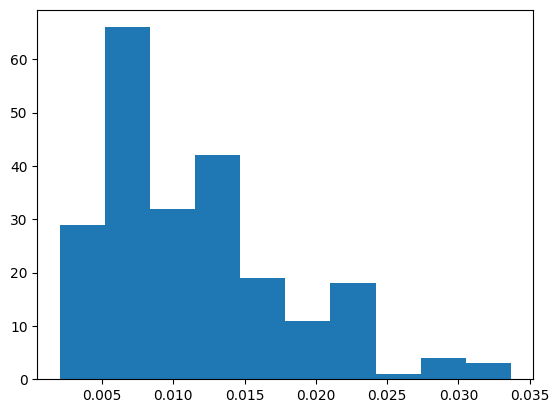

In [6]:
vars = data_summary_df['rt_sd'].to_list()
fig = plt.hist(vars)

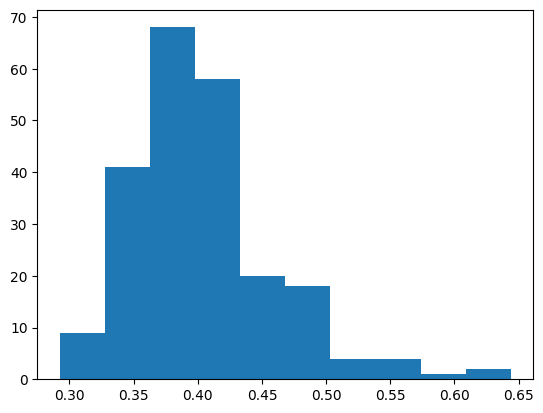

In [7]:
vars = data_summary_df['rt_mean'].to_list()
fig = plt.hist(vars)

In [8]:
behavioral_model = """
# JAGS implementation of the EZ Bayesian 
# hierarchical drift diffusion model
model {
  # Priors for hierarchical drift diffusion model parameters
  bound_mean ~ dnorm(1.50, (0.20^-2))T( 0.10, 3.00)
  drift_mean ~ dnorm(0.50, (0.50^-2))
  nondt_mean ~ dnorm(0.30, (0.06^-2))T( 0, )
  bound_sdev ~ dunif(0.01, 1.00)
  drift_sdev ~ dunif(0.01, 3.00)
  nondt_sdev ~ dunif(0.01, 0.50)
  
  for (p in 1:length(meanRT)) {
    # Hierarchical distributions of person-specific
    # diffusion model parameters.  Here, drift rate
    # is the criterion.
    drift[p] ~ dnorm(drift_mean, (drift_sdev^-2))
    bound[p] ~ dnorm(bound_mean, (bound_sdev^-2))T( 0.10, 3.00)
    nondt[p] ~ dnorm(nondt_mean, (nondt_sdev^-2)) T(0.05, )

    # Forward equations from EZ Diffusion
    ey[p]  = exp(-bound[p] * drift[p])
    Pc[p]  = 1 / (1 + ey[p])
    PRT[p] = 2 * pow(drift[p], 3) / bound[p] * 
             pow(ey[p] + 1, 2) / (2 * -bound[p] * 
             drift[p] * ey[p] - ey[p] * ey[p] + 1)
    MDT[p] = (bound[p] / (2 * drift[p])) * 
             (1 - ey[p]) / (1 + ey[p])
    MRT[p] = MDT[p] + nondt[p]

    # Sampling distributions for summary statistics
    correct[p] ~ dbin(Pc[p], nTrials[p])
    varRT[p]   ~ dnorm(1/PRT[p], 0.5*(correct[p]-1) 
                                 * PRT[p] * PRT[p])
    meanRT[p]  ~ dnorm(MRT[p], PRT[p] * correct[p])
  }
}
"""

In [9]:
# General setup
n_chains = 4
n_iter = 10000
n_burnin = 1000
thin = 10

# data for JAGS
data = dict(
    nTrials = data_summary_df['num_trials'].to_list(),
    meanRT=data_summary_df['rt_mean'].to_list(), 
    varRT = data_summary_df['rt_sd'].to_list(),
    correct = data_summary_df['accuracy_sum'].to_list(),
)

init = { "drift" : np.random.normal(0, 0.1, len(data['nTrials'])) }

#call JAGS and draw samples
model = pyjags.Model(
    progress_bar = True,
    code    = behavioral_model,
    data    = data,
    init    = init,
    adapt   = n_burnin,
    chains  = n_chains,
    threads = 10
)

# Specify parameters to keep track of
vars = ['drift', 'bound', 'nondt', 'drift_mean', 'bound_mean', 'nondt_mean']
samples = model.sample(
    iterations = n_iter,
    thin=thin,
    vars=vars
)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 12879 of 40000, elapsed 0:00:05, remaining 0:00:11
sampling: iterations 31262 of 40000, elapsed 0:00:10, remaining 0:00:03
sampling: iterations 40000 of 40000, elapsed 0:00:11, remaining 0:00:00


Plot the results

In [10]:
inference_data = az.from_pyjags(samples)

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_79151/2904385144.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 640x480 with 0 Axes>

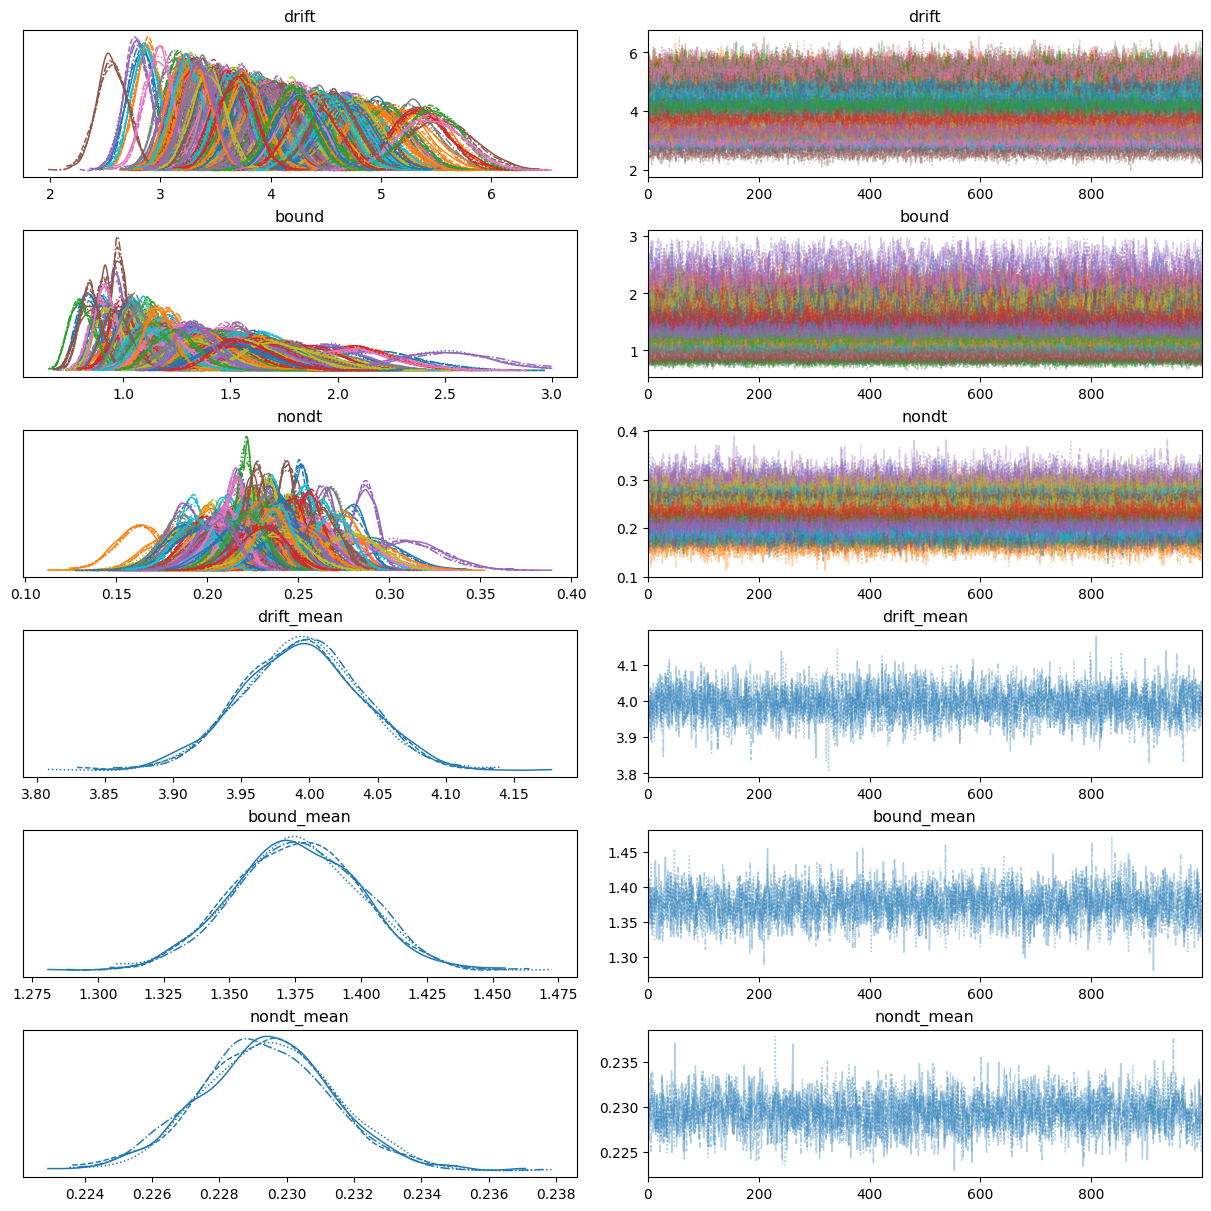

In [11]:
plt.rcParams['figure.constrained_layout.use'] = True

fig = plt.figure()

vars = ['drift', 'bound', 'nondt', 'drift_mean', 'bound_mean', 'nondt_mean']
axes = az.plot_trace(inference_data, vars)

fig.tight_layout()
plt.show()

---
#### Questions:
1. I have a very high accuracy rate - because only go-trials is a very simple reaction task (~.99) - and with so super high accuracies there is a problem with the drift/boundary trade-off.
2. Is there any way to somehow model left vs right using EZBHDDM?
3. Is there any way to model omissions (or is this worth it?). Its literally 5 trials in the data.
4. The estimates of non-decision time look bad.

---
## Behavioral model: Wienner model

In [413]:
# read data
data_participants_df = pd.read_csv('../data/data_participants.csv')
data_participants_df['y'] = data_participants_df.apply(lambda row: -row['rt'] if row['response_type'] == 0 else row['rt'], axis=1)
data_participants_df['y_side'] = data_participants_df.apply(lambda row: -row['rt'] if row['go_condition'] == 'left' else row['rt'], axis=1)
df_cleaned = data_participants_df.copy().dropna()
df_cleaned = df_cleaned[df_cleaned['rt']>.15]
df_cleaned

,Unnamed: 0,go_condition,rt,response_type,omission,ID,index,BIS,AAC-FULL,Dickman-Impulsivity,y,y_side
0,0,left,0.483555,1,False,0,1,0.584046,-0.712524,2.096673,0.483555,-0.483555
1,1,right,0.300505,1,False,0,1,0.584046,-0.712524,2.096673,0.300505,0.300505
2,2,right,0.350223,1,False,0,1,0.584046,-0.712524,2.096673,0.350223,0.350223
3,3,left,0.300410,1,False,0,1,0.584046,-0.712524,2.096673,0.300410,-0.300410
4,4,right,0.267293,1,False,0,1,0.584046,-0.712524,2.096673,0.267293,0.267293
...,...,...,...,...,...,...,...,...,...,...,...,...
72638,72638,right,0.215547,1,False,224,225,-0.592763,-0.840509,-0.928947,0.215547,0.215547
72639,72639,right,0.340811,1,False,224,225,-0.592763,-0.840509,-0.928947,0.340811,0.340811
72640,72640,right,0.271382,1,False,224,225,-0.592763,-0.840509,-0.928947,0.271382,0.271382
72641,72641,right,0.410525,1,False,224,225,-0.592763,-0.840509,-0.928947,0.410525,0.410525


In [422]:
wienner_model = '''
model {
    # Priors for hierarchical drift diffusion model parameters
    bound_mean ~ dnorm(1.50, (0.20^-2))T( 0.10, 3.00)
    drift_mean ~ dnorm(0.50, (0.50^-2))
    nondt_mean ~ dnorm(0.30, (0.06^-2))T( 0, )
    bound_sdev ~ dunif(0.01, 1.00)
    drift_sdev ~ dunif(0.01, 3.00)
    nondt_sdev ~ dunif(0.01, 0.50)
  
    for (p in 1:nparts) {
        drift[p] ~ dnorm(drift_mean, pow(drift_sdev, -2))
        bound[p] ~ dnorm(bound_mean, pow(bound_sdev,-2))T(0.1, 3.0)
        nondt[p] ~ dnorm(nondt_mean, pow(nondt_sdev,-2))T(0.0, )
    }

    ##########
    # Wiener likelihood
    for (i in 1:N) {
        # Observations of accuracy*RT for DDM process of rightward/leftward RT
        y[i] ~ dwiener(bound[participant[i]], nondt[participant[i]], .5, drift[participant[i]])
    }
}
'''

In [423]:
pyjags.modules.load_module('wiener')

n_chains = 2
n_iter = 1000
n_burnin = 1000
thin = 1

N = len(df_cleaned)
y = df_cleaned['y'].to_list()
rt = df_cleaned['rt'].to_list()
participant = df_cleaned['index'].to_list()
nparts = len(np.unique(participant))

minrt = np.zeros(nparts)
for p in range(0, nparts):
    minrt[p] = np.min(df_cleaned[df_cleaned['index'] == (p + 1)]['rt'])

initials = []
for c in range(0, n_chains):
    chaininit = {
        'drift_mean': np.random.uniform(-4., 4.), 
        'bound_mean': np.random.uniform(1, 2),
        'nondt_mean': np.random.uniform(0.05, .3),
        'bound': np.random.uniform(1, 2., size=nparts),
        'nondt': np.random.uniform(0.05, .3, size=nparts),
        'drift': np.random.uniform(-4., 4., size=nparts),
    }
    for p in range(0, nparts):
        chaininit['nondt'][p] = np.random.uniform(0., minrt[p] / 2)
    initials.append(chaininit)

model = pyjags.Model(
    code=wienner_model, 
    init=initials,         
    data=dict(
        y=y, 
        N=N, 
        nparts=nparts,
        participant=participant
    ),
    chains=n_chains, 
    adapt=n_burnin, 
    threads=10,
    progress_bar=True
)

vars = ['drift', 'bound', 'nondt', 'drift_mean', 'bound_mean', 'nondt_mean']
samples = model.sample(
    n_iter, 
    vars=vars, 
    thin=thin
)

adapting: iterations 74 of 2000, elapsed 0:00:06, remaining 0:02:28
adapting: iterations 340 of 2000, elapsed 0:00:15, remaining 0:01:15
adapting: iterations 535 of 2000, elapsed 0:00:20, remaining 0:00:56
adapting: iterations 731 of 2000, elapsed 0:00:30, remaining 0:00:52
adapting: iterations 992 of 2000, elapsed 0:00:40, remaining 0:00:41
adapting: iterations 1189 of 2000, elapsed 0:00:45, remaining 0:00:31
adapting: iterations 1387 of 2000, elapsed 0:00:55, remaining 0:00:24
adapting: iterations 1519 of 2000, elapsed 0:01:00, remaining 0:00:19
adapting: iterations 1717 of 2000, elapsed 0:01:05, remaining 0:00:11
adapting: iterations 1915 of 2000, elapsed 0:01:15, remaining 0:00:03
adapting: iterations 2000 of 2000, elapsed 0:01:16, remaining 0:00:00
sampling: iterations 68 of 2000, elapsed 0:00:05, remaining 0:02:23
sampling: iterations 332 of 2000, elapsed 0:00:15, remaining 0:01:15
sampling: iterations 530 of 2000, elapsed 0:00:20, remaining 0:00:55
sampling: iterations 728 of 20

Plot the results

In [424]:
inference_data = az.from_pyjags(samples)

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_41438/2904385144.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 640x480 with 0 Axes>

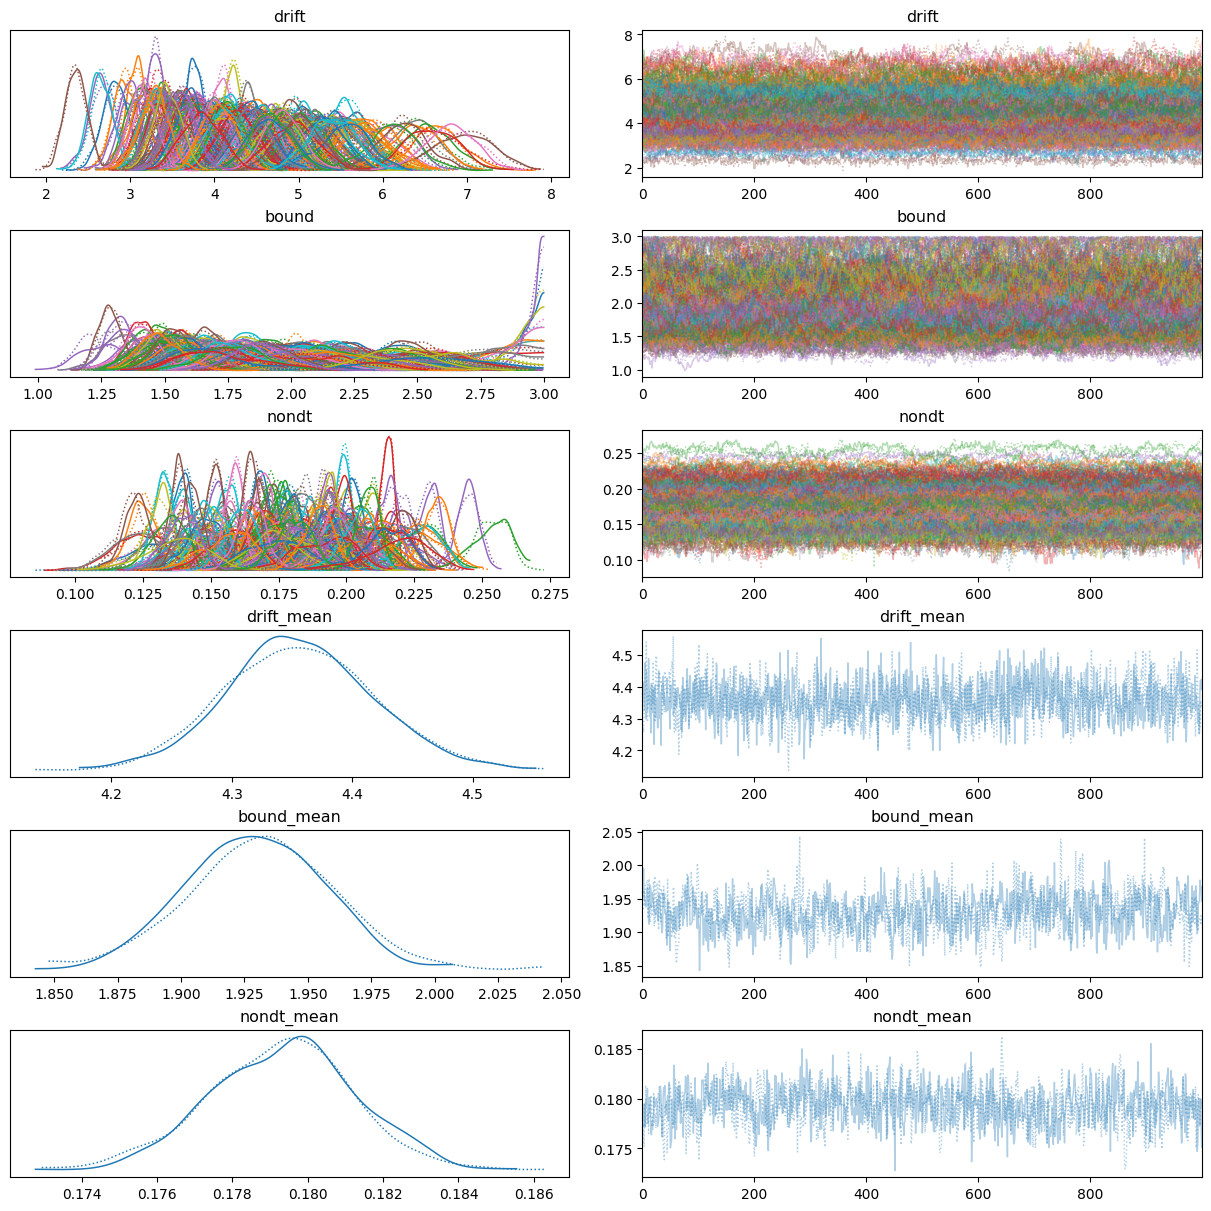

In [425]:
plt.rcParams['figure.constrained_layout.use'] = True

fig = plt.figure()

vars = ['drift', 'bound', 'nondt', 'drift_mean', 'bound_mean', 'nondt_mean']
axes = az.plot_trace(inference_data, vars)

fig.tight_layout()
plt.show()